In [1]:
import numpy as np
import os

dft_path = "/home/juleguy/dft_comput"

json_cache_location_list = [os.environ["DATA"] + "/00_datasets/DFT/cache_OD9_step7.json",
                            os.environ["DATA"] + "/00_datasets/DFT/cache_OPT_OD9_Marta_filtered.json",
                            os.environ["DATA"] + "/00_datasets/DFT/cache_OPT_OD9_0.json",
                            os.environ["DATA"] + "/00_datasets/DFT/cache_OPT.json"]

init_dataset_smiles = ["C"]

test_dataset_path = os.environ["DATA"] + "/00_datasets/DFT/OD9_7_smi_datasets/validation.smi"

bbo_data_path = os.environ["DATA"] + "/07_BBO/03_bbo_optim/02.02_optim_HOMO_subgrid_from_methane_10_runs"
bbo_single_evomol_optim_path = os.environ["DATA"] + "/07_BBO/03_bbo_optim/02.03_optim_HOMO_single_evomol_optim_from_methane_10_runs"
bbo_matern_path = os.environ["DATA"] + "/07_BBO/03_bbo_optim/02.04_optim_HOMO_subgrid_Matern_from_methane_10_runs"
bbo_rerun_path = os.environ["DATA"] + "/07_BBO/03_bbo_optim/02.06_optim_HOMO_subgrid_rerun_baseline_from_methane_10_runs"
evomol_data_path = os.environ["DATA"] + "/07_BBO/03_bbo_optim/02.01_EvoMol_from_methane_optim_HOMO_10_runs"

figures_dir = os.environ["FIGURES"] + "/07_BBO/03_bbo_optim/02.10_plot_BBO_EvoMol_10_runs"


# Parallel parameters
n_jobs_per_model = 10

# BBO parameters
n_models_bagging = 10

test_dataset_size = 1000
save_surrogate_model = False
period_save = 1
period_compute_test_predictions = 1
max_obj_calls = 1000

# EvoMol parameters
evomol_pop_max_size = 300
evomol_max_steps = 50
evomol_k_to_replace = 10
evomol_init_pop_size = 10
evomol_n_runs = 10
evomol_n_best_retrieved = 1
evomol_init_pop_strategy = "random_weighted"

# Problem action space
max_heavy_atoms = 9
heavy_atoms = "C,N,O,F"


ECDF_TARGETS = np.arange(-10, -1, 0.01)
ERT_TARGETS = np.arange(-10, -1, 0.5)

In [2]:
from os import makedirs
makedirs(figures_dir, exist_ok=True)

In [3]:
from bbo.objective_dft import DFTEnergyObjective
from bbo.objective import QEDObjective

objective = DFTEnergyObjective(property="homo", cache_location=None, json_cache_location_list=json_cache_location_list,
                               n_jobs=n_jobs_per_model, working_dir=dft_path)

# objective = QEDObjective(cache_location=None, n_jobs=n_jobs_per_model)

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct
from sklearn.kernel_ridge import KernelRidge


models = [
    ("GPR(1*RBF())", GaussianProcessRegressor(1 * RBF(1.0), alpha=0.1)),
    ("GPR(1*Matern(nu=2.5))", GaussianProcessRegressor(1 * Matern(length_scale=1, nu=2.5), alpha=0.1))
]


In [5]:
from bbo.model import BaggingSurrogateModel, GPRSurrogateModelWrapper, DummySurrogateModelWrapper

# tuples (wrapper str name, wrapper class, lambda condition of use with a model m, parameters dict)

surrogate_wrappers = [
    ("GPRWrapper", GPRSurrogateModelWrapper, lambda m : isinstance(m, GaussianProcessRegressor), {}),
    ("Bagging", BaggingSurrogateModel, lambda m: True, {"n_models": n_models_bagging, "n_jobs": n_jobs_per_model}),
    ("Surrogate", DummySurrogateModelWrapper, lambda m: True, {})
]

surrogate_models = []
    
for model in models:
    
    model_name, model_instance = model
    
    for surrogate_wrapper in surrogate_wrappers:

        wrapper_name, wrapper_class, lambda_f, param_dict = surrogate_wrapper
        
        if lambda_f(model_instance):            
            surrogate_models.append(
                (
                    wrapper_name + "(" + model_name + ")", # Surrogate name
                    wrapper_class(base_model=model_instance, **param_dict)
                )
    )
    
print(surrogate_models)

[('GPRWrapper(GPR(1*RBF()))', GPRSurrogateModelWrapper(base_model=None)), ('Bagging(GPR(1*RBF()))', BaggingSurrogateModel(base_model=None, n_jobs=10, n_models=10)), ('Surrogate(GPR(1*RBF()))', DummySurrogateModelWrapper(base_model=None)), ('GPRWrapper(GPR(1*Matern(nu=2.5)))', GPRSurrogateModelWrapper(base_model=None)), ('Bagging(GPR(1*Matern(nu=2.5)))', BaggingSurrogateModel(base_model=None, n_jobs=10, n_models=10)), ('Surrogate(GPR(1*Matern(nu=2.5)))', DummySurrogateModelWrapper(base_model=None))]


In [6]:
from bbo.descriptor import SOAPDesc, MBTRDesc, ShinglesVectDesc

descriptors = [
    ("Shingles_count", ShinglesVectDesc(cache_location=None, count=True))
]

In [7]:
from bbo.merit import ExpectedImprovementMerit, SurrogateValueMerit

# Tuples (merit str name, merit str class, lambda surrogate s : can be used with)

merit_functions = [("Expected_improvement", ExpectedImprovementMerit, lambda s: not isinstance(s, DummySurrogateModelWrapper)),
                   ("Surrogate_value", SurrogateValueMerit, lambda s: isinstance(s, DummySurrogateModelWrapper))]

In [8]:
def build_grid(surrogate_models, descriptors, merit_functions):
    """
    Returning a list of tuple describing all compatible modules
    """
    
    grid = []
    
    for surrogate_model in surrogate_models:
        for descriptor in descriptors:
            for merit_function in merit_functions:
                    
                if merit_function[2](surrogate_model[1]):
                    grid.append((surrogate_model, descriptor, merit_function))
                        
    return grid
    

In [9]:
from os.path import join, exists
import csv

def extract_dataset(dataset_path, steps_path):
    
    dataset_introduction_step = []
    dataset_smiles = []
    dataset_obj_value = []
    dataset_n_calls = []
    
    with open(dataset_path, "r") as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            
            # Extracting data using both version of the code : with or without the "success" column
            try:
                introduction_step, smiles, obj_value, n_calls = row
                success = True
            except ValueError as e:
                introduction_step, smiles, obj_value, n_calls, success = row
                
            if i > 0 and int(introduction_step) > 0 and success:
                
                dataset_introduction_step.append(int(introduction_step))
                dataset_smiles.append(smiles)
                dataset_obj_value.append(float(obj_value))
                dataset_n_calls.append(int(n_calls))
            
    return dataset_introduction_step, dataset_smiles, dataset_obj_value, dataset_n_calls
    
def extract_test_predictions(path):
    
    test_mae = []
    test_step = []
    
    with open(path, "r") as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if i > 0:
                test_step.append(int(row[0]))
                test_mae.append(float(row[1]))
                
    return test_step, test_mae


def extract_bbo_data(grid, output_data_path, run_ids, data=None, categories=None, extra_categories_keys=None, extra_categories_values=None):

    if data is None:
        data = []
    
    if categories is None:
        categories = {"model": [], "surrogate": [], "descriptor": [], "merit": []}
    
    if extra_categories_keys is not None:
        for i, extra_categories_key in enumerate(extra_categories_keys):
            
            if extra_categories_key not in categories:
                categories[extra_categories_key] = []
                
            if extra_categories_values[i] not in categories[extra_categories_key]:
                categories[extra_categories_key].append(extra_categories_values[i])
    
    
    for model_params in grid:
        
        for run_id in run_ids:
        
            surrogate_model, descriptor, merit = model_params

            surrogate_name = surrogate_model[0]

            surrogate_instance = surrogate_model[1]
            descriptor_name = descriptor[0]
            descriptor_instance = descriptor[1]
            merit_name = merit[0]
            Merit_class = merit[1]
            
            model_name = "-".join([surrogate_name, descriptor_name, merit_name])
            model_path = join(join(output_data_path, model_name), str(run_id))

            surrogate_type = surrogate_name.split("(")[0]
            
            if exists(model_path):
            
                model_type = "(".join(surrogate_name.split("(")[1:])
                if model_type not in categories["model"]:
                    categories["model"].append(model_type)
                if descriptor_name not in categories["descriptor"]:
                    categories["descriptor"].append(descriptor_name)
                if merit_name not in categories["merit"]:
                    categories["merit"].append(merit_name)
                if surrogate_type not in categories["surrogate"]:
                    categories["surrogate"].append(surrogate_type)

                # Extracting dataset.csv file
                dataset_introduction_step, dataset_smiles, dataset_obj_value, dataset_obj_calls = extract_dataset(join(model_path, "dataset.csv"), join(model_path, "steps.csv"))

                # Extracting test_predictions.csv file
                test_step, test_mae = extract_test_predictions(join(model_path, "surrogate", "test_predictions.csv"))

                if len(test_mae) > 0:
                    test_mae_first_step = [test_mae[0]]
                    test_mae_last_step = [test_mae[-1]]
                else:
                    test_mae_first_step = []
                    test_mae_last_step = []

                # Recording data
                curr_model_data = {
                    "name": model_name,
                    "run_id": run_id,
                    "surrogate": surrogate_type,
                    "model": model_type,
                    "descriptor": descriptor_name,
                    "merit": merit_name,
                    "path": model_path,
                    "dataset_introduction_step": dataset_introduction_step,
                    "dataset_smiles": dataset_smiles,
                    "dataset_obj_value": dataset_obj_value,
                    "dataset_obj_calls": dataset_obj_calls,
                    "test_step": test_step,
                    "test_mae": test_mae,
                    "test_mae_last_step": test_mae_last_step,
                    "test_mae_first_step": test_mae_first_step 
                }
                if extra_categories_keys is not None:
                    for i, extra_categories_key in enumerate(extra_categories_keys):
                        curr_model_data[extra_categories_key] = extra_categories_values[i]

                data.append(curr_model_data)
        
    return data, categories


def extract_evomol_data(path, run_ids):
    
    data = []
    
    for run_id in run_ids:
        
        curr_model_path = join(path, str(run_id))
        
        curr_model_obj_calls = []
        curr_model_obj_values = []
        
        with open(join(curr_model_path, "all_generated.csv"), "r") as f:
            reader = csv.reader(f)
            for i, row in enumerate(reader):
                if i > 0:
                    curr_model_obj_calls.append(int(row[2]))
                    curr_model_obj_values.append(float(row[3]))
                    
        data.append({
            "name": "EvoMol",
            "run_id": run_id,
            "dataset_obj_calls": curr_model_obj_calls,
            "dataset_obj_value": curr_model_obj_values
        })
                
    return data, []
            


In [10]:
import numpy as np

def concatenate_data_on_filters(data, category_keys, category_values):
    
    data_keys = []
    
    for model_data in data:
        for model_data_key in model_data.keys():
            if model_data_key not in data_keys and (isinstance(model_data[model_data_key], list)):
                data_keys.append(model_data_key)
    
    
    concatenated_data = {
        category_keys[i]: category_values[i] for i in range(len(category_keys))
    }
    
    for key in data_keys:
        if key not in category_keys:
            concatenated_data[key] = []
            
            
    exists_concatenated_data = False
    for model_data in data:
        
        filter_ok = True
        for i, category_key in enumerate(category_keys):
            if model_data[category_key] != category_values[i]:
                filter_ok = False
        
        if filter_ok:    
            exists_concatenated_data = True
            for key in data_keys:
                if key not in category_keys and key in model_data:
                    concatenated_data[key] = np.concatenate([concatenated_data[key], model_data[key]])
                        
    return concatenated_data, exists_concatenated_data

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

def plot_all_points(data, exp_name, categories_keys):
        
    plt.figure(figsize=(40, 60))
    
    for i, model_data in enumerate(data):
        
        plt.subplot(15, 5, i+1)
                
        plt.xlim(1, 10100)
        plt.ylim(-10, -1)
        plt.title(" ".join([key + "=" + model_data[key] for key in categories_keys]))
        
        sns.scatterplot(x=model_data["dataset_obj_calls"], 
                        y=model_data["dataset_obj_value"])
                
        
    plt.savefig(join(figures_dir, "calls_values_all_models" + exp_name + ".png"))
    plt.show()
        

In [12]:
from itertools import product

def plot_distribution(bbo_data, evomol_data, bbo_categories, bbo_category_keys):
    
    plt.figure(figsize=(15, 10))
    
    bbo_category_values = [bbo_categories[key] for key in bbo_category_keys]
    all_combinations = product(*bbo_category_values)
    
    # Plot BBO
    for curr_category_values in all_combinations:
        
        all_category_data, exists_data = concatenate_data_on_filters(bbo_data, bbo_category_keys, curr_category_values)        
        if exists_data:
            sns.distplot(all_category_data["dataset_obj_value"], label="BBO " + str(curr_category_values))
        
    # Plot EvoMol
    all_evomol_data, exists_data = concatenate_data_on_filters(evomol_data, ["name"], ["EvoMol"])
    
    sns.distplot(all_evomol_data["dataset_obj_value"], label="EvoMol")
    
    plt.legend()
    
    plt.savefig(join(figures_dir, "dist_obj_values.png"))
    plt.show()

        

In [13]:
from bbo.evaluation import compute_ecdf

def plot_ecdf(bbo_data, evomol_data, bbo_categories, bbo_category_keys):
    
        
    plt.figure(figsize=(15, 10))
    plt.xlim(1, 10100)
    plt.ylim(0, 1)
#     plt.xscale("log")
    
    bbo_category_values = [bbo_categories[key] for key in bbo_category_keys]
    all_combinations = list(product(*bbo_category_values))
    
    data_dict = {
        combination: {"obj_calls_list": [], "obj_values_list": []} for combination in all_combinations
    }
    data_dict["EvoMol"] = {"obj_calls_list": [], "obj_values_list": []}
    
    # BBO models data
    for bbo_model in bbo_data:
        for combination in all_combinations:
            
            match = True
            for i, bbo_category_key in enumerate(bbo_category_keys):
                if bbo_model[bbo_category_key] != combination[i]:
                    
                    match = False
            
            if match:
                data_dict[combination]["obj_calls_list"].append(bbo_model["dataset_obj_calls"])
                data_dict[combination]["obj_values_list"].append(bbo_model["dataset_obj_value"])
    
    for combination in all_combinations:
        if len(data_dict[combination]["obj_calls_list"]) > 0:
            complete_obj_calls, ecdf_vect = compute_ecdf(
                obj_calls_list=data_dict[combination]["obj_calls_list"],
                obj_values_list=data_dict[combination]["obj_values_list"],
                targets=ECDF_TARGETS
            )

            sns.lineplot(complete_obj_calls, ecdf_vect, label="BBO " + str(combination))
    
    # EvoMol data
    for evomol_model in evomol_data:
        data_dict["EvoMol"]["obj_calls_list"].append(evomol_model["dataset_obj_calls"])
        data_dict["EvoMol"]["obj_values_list"].append(evomol_model["dataset_obj_value"])
        
    complete_obj_calls_evomol, ecdf_vect_evomol = compute_ecdf(
        obj_calls_list=data_dict["EvoMol"]["obj_calls_list"],
        obj_values_list=data_dict["EvoMol"]["obj_values_list"],
        targets=ECDF_TARGETS
    )

    
    sns.lineplot(complete_obj_calls_evomol, ecdf_vect_evomol, label="EvoMol")
    plt.legend()
    
    ax2 = plt.twinx()
    ax2.set_ylim(min(ECDF_TARGETS), max(ECDF_TARGETS))
    
    plt.savefig(join(figures_dir, "ECDF.png"))
    plt.show()


In [14]:
def plot_test_dataset_mae(bbo_data, bbo_categories, bbo_category_keys):
    
    plt.figure(figsize=(15, 10))
    plt.xlim(1, 10100)
    plt.xscale("log")
    
    bbo_category_values = [bbo_categories[key] for key in bbo_category_keys]
    all_combinations = product(*bbo_category_values)
    
    
    # Plot BBO
    for curr_category_values in all_combinations:
        
        all_category_data, exists_data = concatenate_data_on_filters(bbo_data, bbo_category_keys, curr_category_values)        
        if exists_data:
            sns.lineplot(all_category_data["test_step"], all_category_data["test_mae"], label="BBO " + str(curr_category_values))

        
    plt.savefig(join(figures_dir, "MAE_test_bbo.png"))
    plt.show()


In [15]:
from bbo.evaluation import compute_ERT
import pandas as pd

def display_ERT(bbo_data, evomol_data, bbo_categories, bbo_category_keys, targets):
    
    ert_dict = {
        "name": []
    }
    
    for target in targets:
        ert_dict[target] = []
        
    
    bbo_category_values = [bbo_categories[key] for key in bbo_category_keys]
    all_combinations = list(product(*bbo_category_values))
    
    data_dict = {
        combination: {"obj_calls_list": [], "obj_values_list": []} for combination in all_combinations
    }
    data_dict["EvoMol"] = {"obj_calls_list": [], "obj_values_list": []}
    
    # BBO models data
    for bbo_model in bbo_data:
        for combination in all_combinations:
            
            match = True
            for i, bbo_category_key in enumerate(bbo_category_keys):
                if bbo_model[bbo_category_key] != combination[i]:
                    
                    match = False
            
            if match:
                data_dict[combination]["obj_calls_list"].append(bbo_model["dataset_obj_calls"])
                data_dict[combination]["obj_values_list"].append(bbo_model["dataset_obj_value"])
    
    for combination in all_combinations:
        if len(data_dict[combination]["obj_calls_list"]) > 0:
            ert_dict["name"].append("BBO " + str(combination))
            ert_vect = compute_ERT(obj_calls_list=data_dict[combination]["obj_calls_list"],
                               obj_values_list=data_dict[combination]["obj_values_list"],
                               targets=targets)
        
            for i, target in enumerate(targets):
                ert_dict[target].append(ert_vect[i])
    
    
    # EvoMol data
    for evomol_model in evomol_data:
        data_dict["EvoMol"]["obj_calls_list"].append(evomol_model["dataset_obj_calls"])
        data_dict["EvoMol"]["obj_values_list"].append(evomol_model["dataset_obj_value"])
   
    evomol_ert_vect = compute_ERT(obj_calls_list=data_dict["EvoMol"]["obj_calls_list"],
                                  obj_values_list=data_dict["EvoMol"]["obj_values_list"],
                                  targets=targets)
    
    ert_dict["name"].append("EvoMol")
    for i, target in enumerate(targets):
        ert_dict[target].append(evomol_ert_vect[i])
            
            
    df = pd.DataFrame.from_dict(ert_dict)
    return df

### Extracting BBO data

In [16]:
import numpy as np

grid = build_grid(surrogate_models, descriptors, merit_functions)
bbo_data, bbo_categories = extract_bbo_data(grid, bbo_data_path, run_ids=np.arange(1, 11), 
                                            extra_categories_keys=["Parallel optim.", "rerun"],
                                            extra_categories_values=["10", "False"])

bbo_data, bbo_categories = extract_bbo_data(grid, bbo_single_evomol_optim_path, 
                                                  run_ids=np.arange(1, 11),
                                                  data=bbo_data, categories=bbo_categories,
                                                  extra_categories_keys=["Parallel optim.", "rerun"],
                                                  extra_categories_values=["single", "False"])

bbo_data, bbo_categories = extract_bbo_data(grid, bbo_matern_path,
                                            run_ids=np.arange(1, 11),
                                            data=bbo_data, categories=bbo_categories,
                                            extra_categories_keys=["Parallel optim.", "rerun"],
                                            extra_categories_values=["10", "False"])

bbo_data, bbo_categories = extract_bbo_data(grid, bbo_rerun_path,
                                            run_ids=np.arange(1, 11),
                                            data=bbo_data, categories=bbo_categories,
                                            extra_categories_keys=["Parallel optim.", "rerun"],
                                            extra_categories_values=["10", "True"])

In [17]:
print(bbo_categories)

{'model': ['GPR(1*RBF()))', 'GPR(1*Matern(nu=2.5)))'], 'surrogate': ['GPRWrapper', 'Bagging', 'Surrogate'], 'descriptor': ['Shingles_count'], 'merit': ['Expected_improvement', 'Surrogate_value'], 'Parallel optim.': ['10', 'single'], 'rerun': ['False', 'True']}


### Extracting EvoMol data

In [18]:
evomol_data, evomol_categories = extract_evomol_data(evomol_data_path, run_ids=np.arange(1, 11))

### Plotting all BBO data

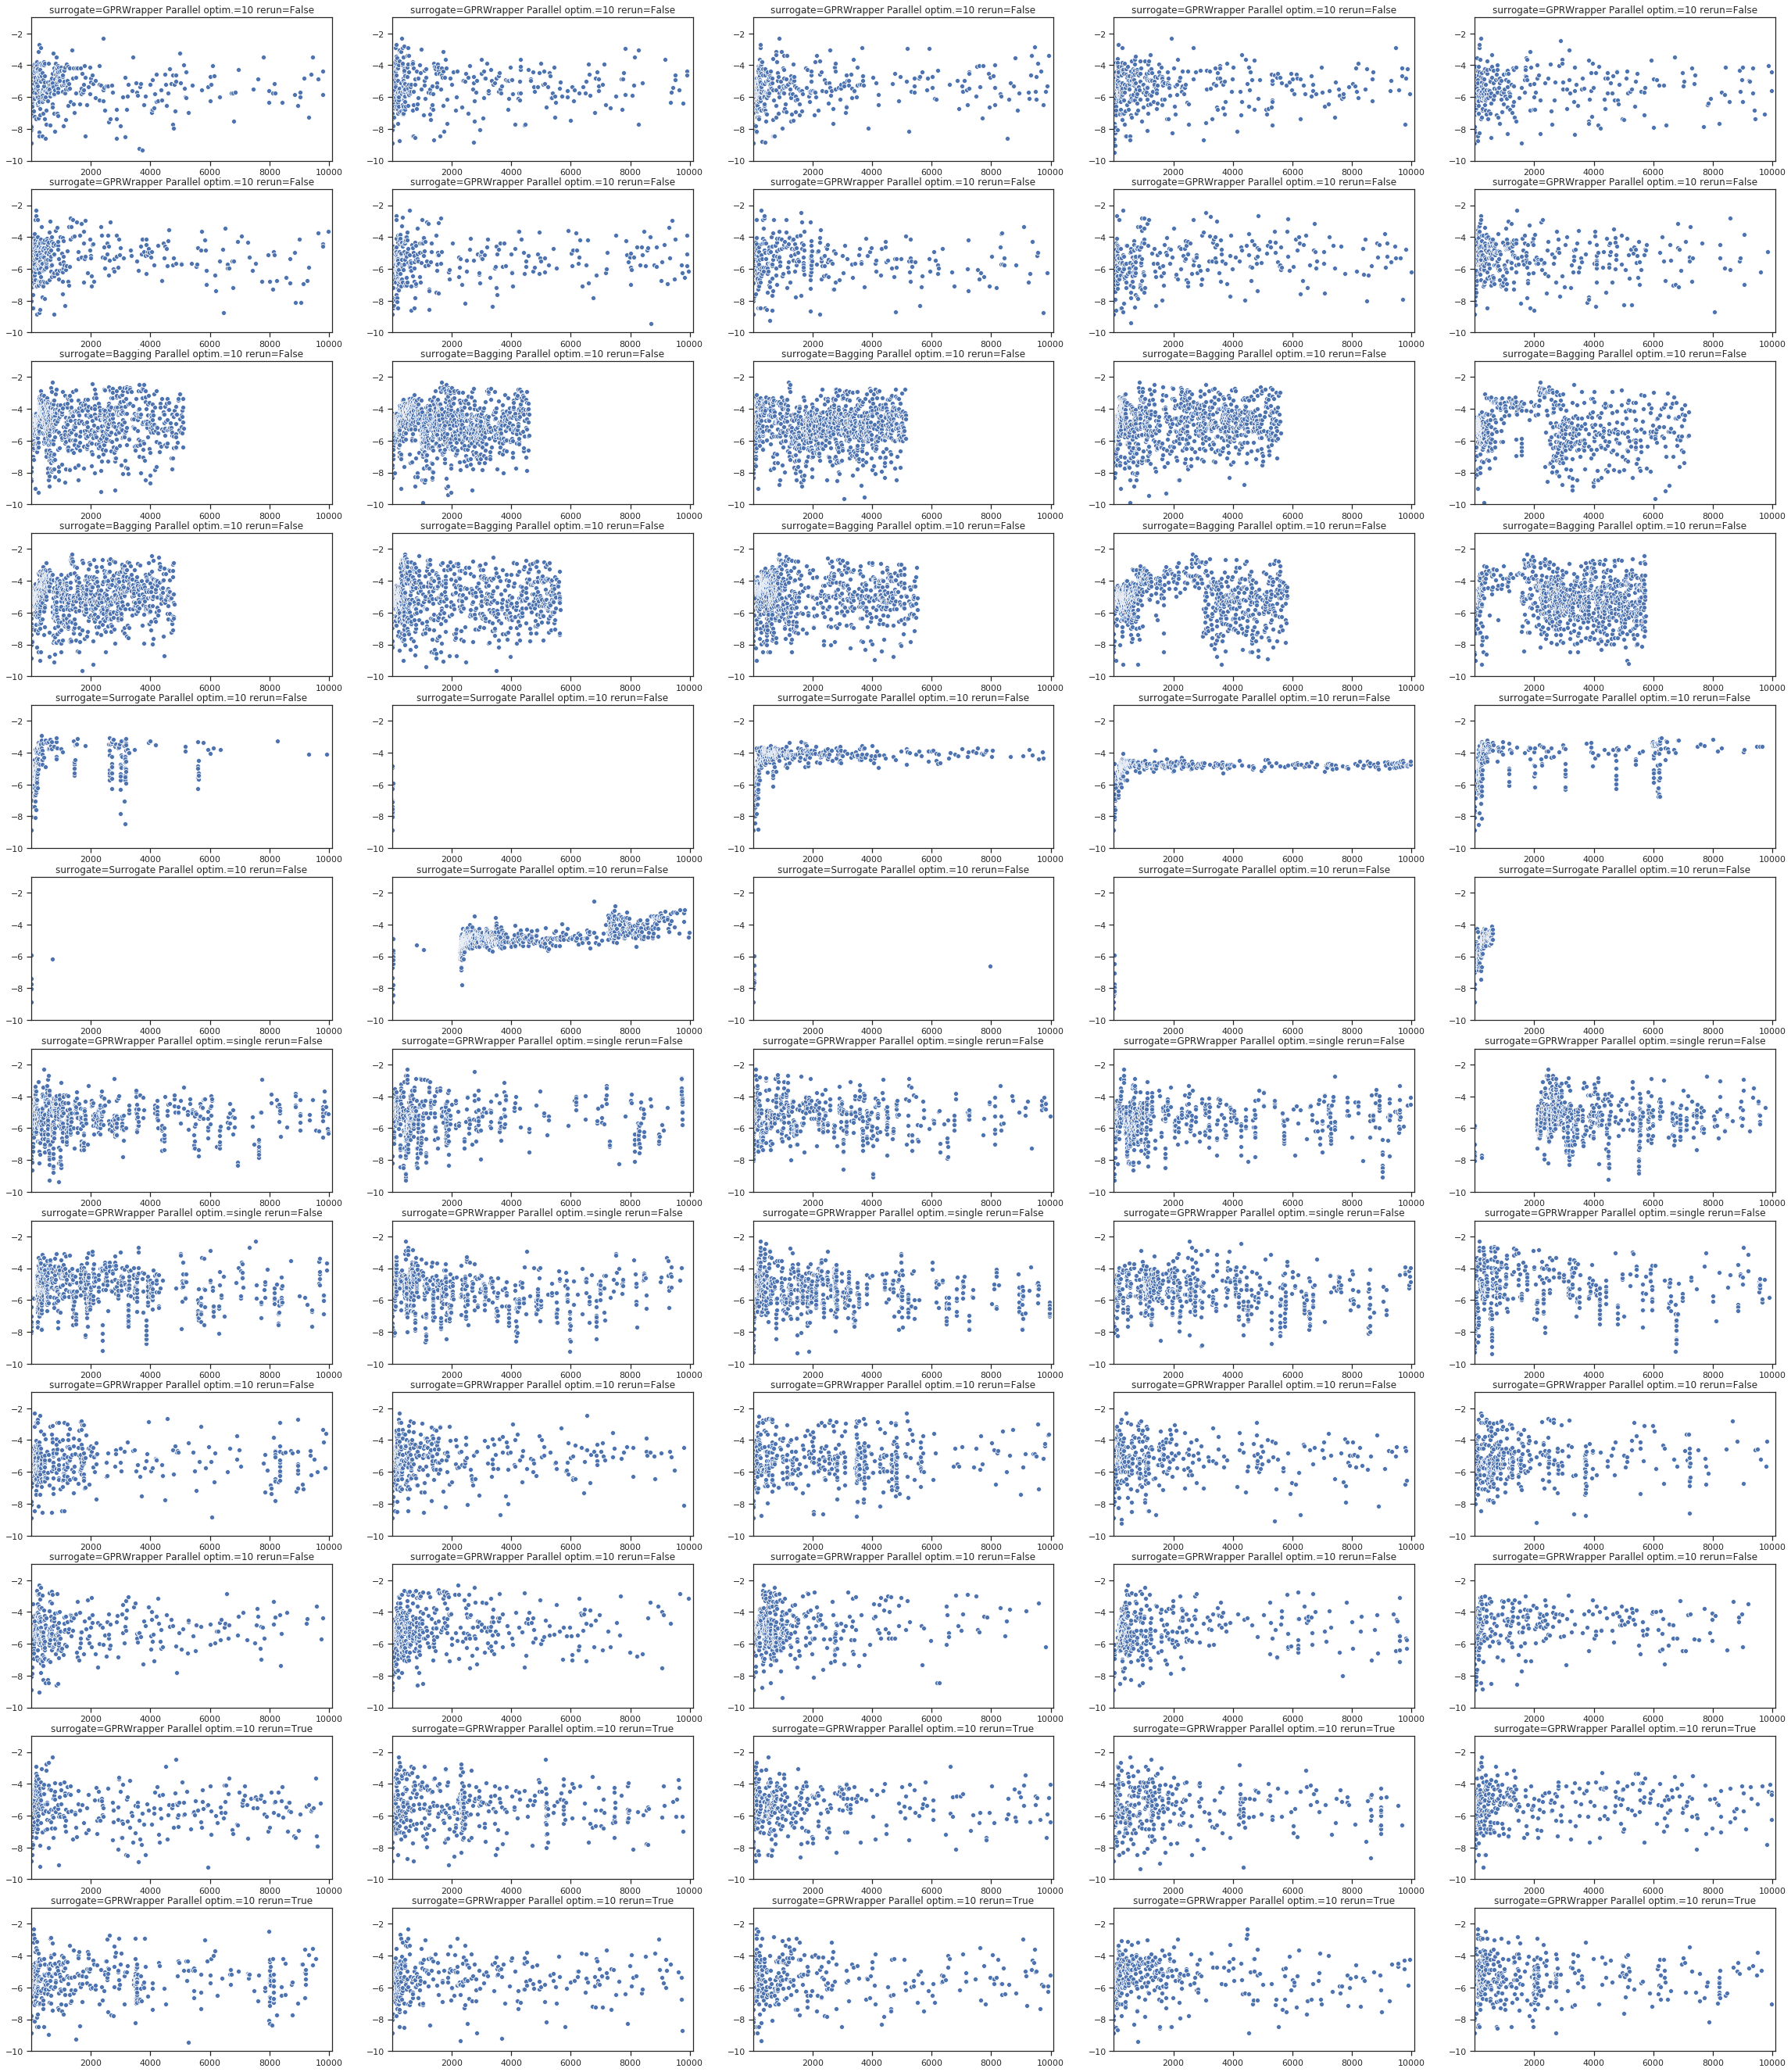

In [19]:
plot_all_points(bbo_data, "BBO", categories_keys=["surrogate", "Parallel optim.", "rerun"])

### Plotting all EvoMol data

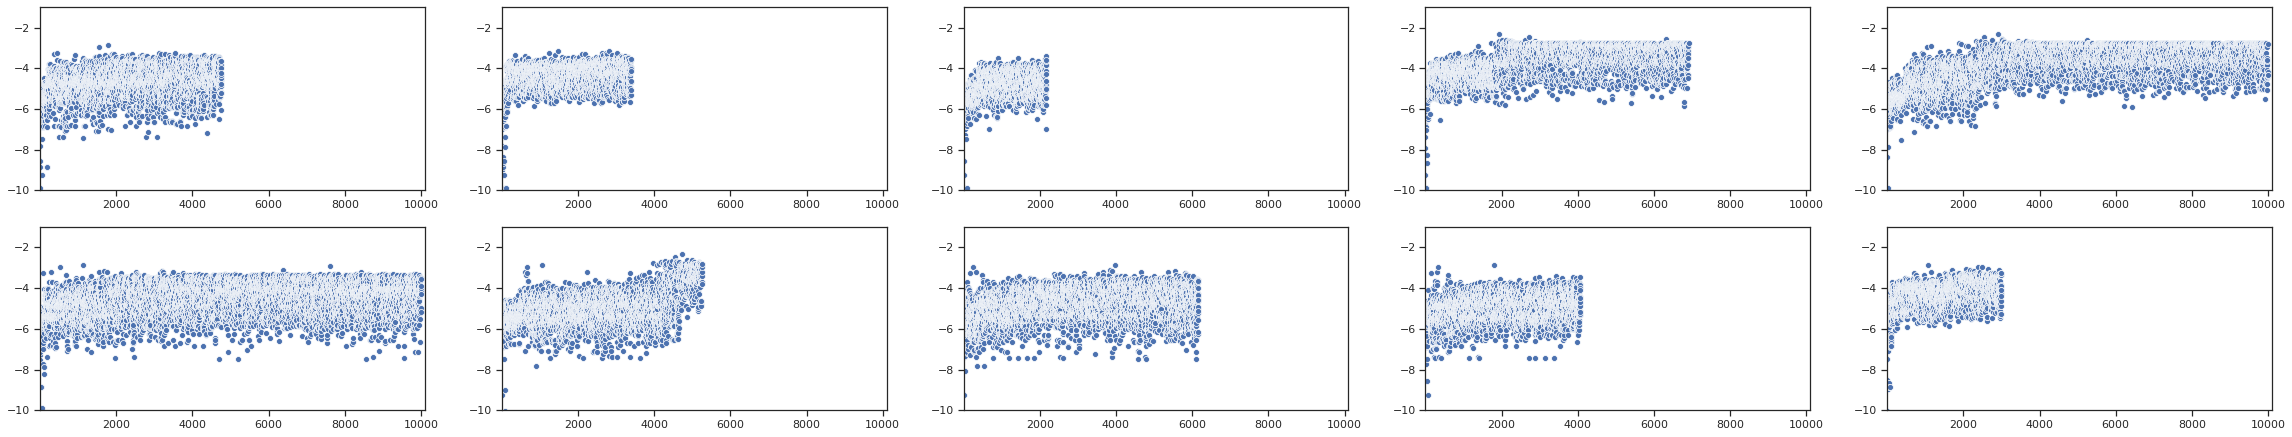

In [20]:
plot_all_points(evomol_data, "EvoMol", categories_keys=[])

### Plotting obj. values distributions

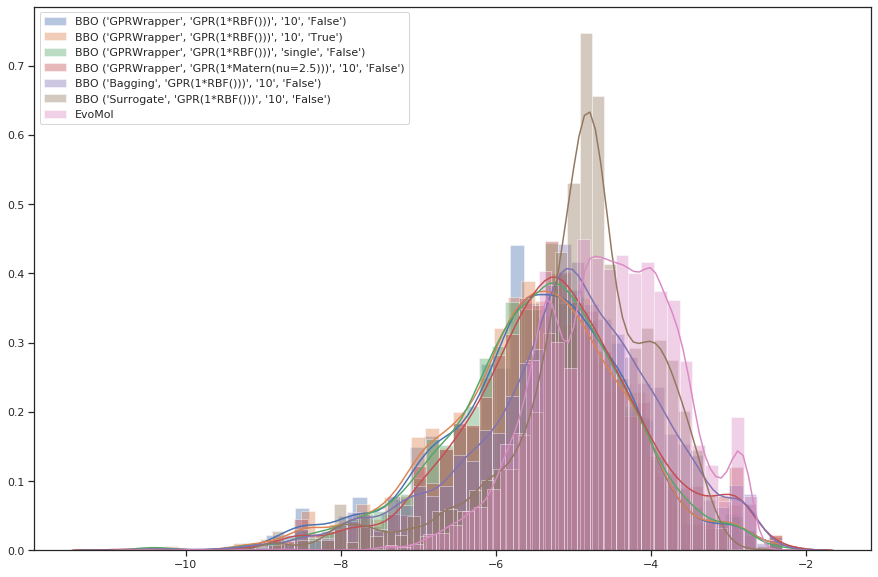

In [21]:
plot_distribution(bbo_data, evomol_data, bbo_categories, ["surrogate", "model", "Parallel optim.", "rerun"])

### Plotting ECDF

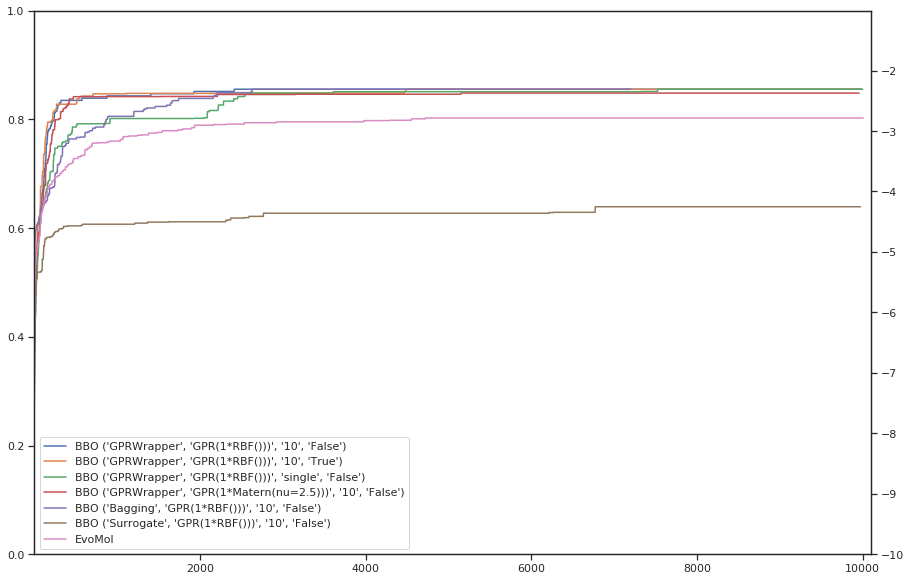

In [22]:
plot_ecdf(bbo_data, evomol_data, bbo_categories,  ["surrogate", "model", "Parallel optim.", "rerun"])

### Plotting MAE evolution

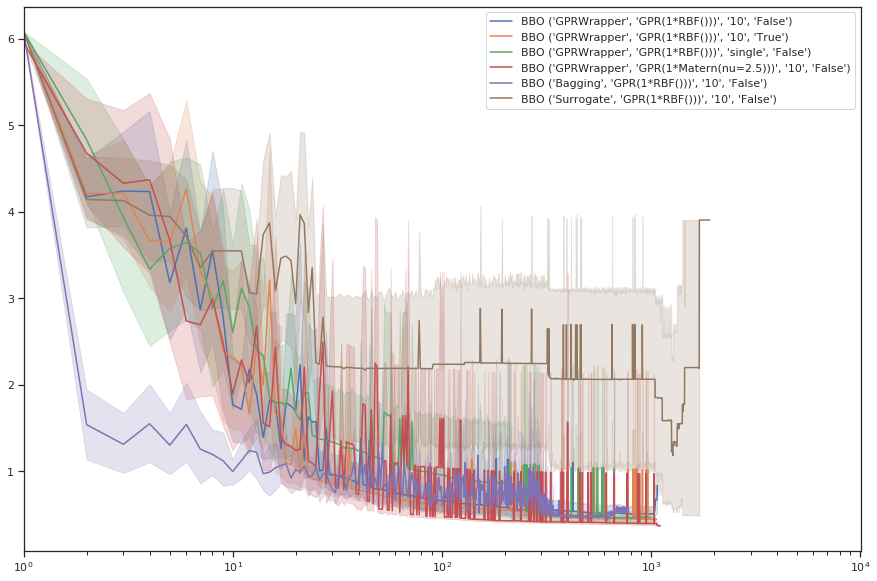

In [23]:
plot_test_dataset_mae(bbo_data, bbo_categories, ["surrogate", "model", "Parallel optim.", "rerun"])

### ERT

In [24]:
display_ERT(bbo_data, evomol_data, bbo_categories,  ["surrogate", "model", "Parallel optim.", "rerun"], ERT_TARGETS)

name  -10.0  -9.5  -9.0  -8.5  \
0  BBO ('GPRWrapper', 'GPR(1*RBF()))', '10', 'Fal...    1.0   1.0   1.0   1.2   
1  BBO ('GPRWrapper', 'GPR(1*RBF()))', '10', 'True')    1.0   1.0   1.0   1.2   
2  BBO ('GPRWrapper', 'GPR(1*RBF()))', 'single', ...    1.0   1.0   1.5   1.6   
3  BBO ('GPRWrapper', 'GPR(1*Matern(nu=2.5)))', '...    1.0   1.0   1.0   1.3   
4    BBO ('Bagging', 'GPR(1*RBF()))', '10', 'False')    1.0   1.0   1.0   1.1   
5  BBO ('Surrogate', 'GPR(1*RBF()))', '10', 'False')    1.1   1.1   1.1   1.4   
6                                             EvoMol    1.3   1.3   1.3   1.7   

   -8.0  -7.5  -7.0  -6.5  -6.0         -5.5         -5.0         -4.5  \
0   1.8   4.2   6.3  17.5  23.6    34.000000    42.900000    72.600000   
1   2.4   4.5   4.5   7.2  14.0    18.300000    28.700000    64.100000   
2   2.7   6.4   7.6  10.0  13.5   255.900000   261.300000   290.300000   
3   2.4   3.2   3.7   4.9  28.4    29.900000    43.900000    88.700000   
4   1.4   1.8   2.5   2.9   3.4     6.900000    11.600000    65.300000   
5   2.7   4.6   5.7  20.1  22.7  1272.428571  1291.142857  1954.833333   
6   1.7   1.7   1.8   2.9   4.1     6.200000    24.900000   132.200000   

     -4.0     -3.5      -3.0          -2.5  -2.0  -1.5  
0   113.3   155.20    164.70  8.517000e+02   inf   inf  
1   103.6   136.60    250.10  7.534000e+02   inf   inf  
2   332.0   453.20    741.60  1.474000e+03   inf   inf  
3   126.3   189.30    247.20  1.516444e+03   inf   inf  
4   229.2   287.30   1148.40  1.367300e+03   inf   inf  
5  2735.4  5941.25  22922.50           inf   inf   inf  
6   241.2   587.80   1549.75  1.419667e+04   inf   inf